In [4]:
# Snippet 1
import requests
import json
import folium
from functools import lru_cache
from shapely.geometry import LineString

# Please add your API key for Google Maps Directions API
API_KEY = ''

# Create a cache for route calculations
@lru_cache(maxsize=None)
def calculate_route(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json?origin={origin[0]},{origin[1]}&destination={destination[0]},{destination[1]}&mode=walking&key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data


# Read the data from the CSV file and extract the conflict zone and camp locations
conflict_zone_locations = []
camp_locations = []

with open('locations.csv', 'r') as file:
    lines = file.readlines()[1:]  # Skip the header line
    for line in lines:
        fields = line.strip().split(',')
        location_name = fields[0]
        location_coordinates = (float(fields[3]), float(fields[4]))
        location_type = fields[5]
        if location_type == 'conflict_zone':
            conflict_zone_locations.append((location_name, location_coordinates))
        elif location_type == 'camp':
            camp_locations.append((location_name, location_coordinates))

# Process each conflict zone
features = []
for zone1 in conflict_zone_locations + camp_locations:
    zone1_name, zone1_coordinates = zone1

    # Calculate routes from the current location to all other conflict zones and camps
    routes = []
    for zone2 in conflict_zone_locations + camp_locations:
        zone2_name, zone2_coordinates = zone2

        # Skip if the locations are the same
        if zone1_name == zone2_name:
            continue

        try:
            # Calculate the route or retrieve from cache
            data = calculate_route(zone1_coordinates, zone2_coordinates)

            # Check if the route is found
            if data['status'] == 'OK':
                # Extract the route coordinates
                coordinates = []
                for step in data['routes'][0]['legs'][0]['steps']:
                    start_location = step['start_location']
                    end_location = step['end_location']
                    coordinates.append((start_location['lat'], start_location['lng']))
                    coordinates.append((end_location['lat'], end_location['lng']))

                # Create a LineString object from the route coordinates
                route_line = LineString(coordinates)

                # Simplify the LineString by reducing the number of points
                tolerance = 0.001  # Adjust the tolorance "up" for more and "down" for fewrer coordinates 
                simplified_route = route_line.simplify(tolerance)

                # Extract the simplified coordinates from the LineString object
                simplified_coordinates = list(simplified_route.coords)

                routes.append({
                    'name': zone2_name,
                    'coordinates': simplified_coordinates
                })

            else:
                print(f"No route found between {zone1_name} and {zone2_name}")

        except Exception as e:
            print(f"Error occurred: {e}")

    # Add the routes as features to the GeoJSON
    if routes:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "MultiLineString",
                "coordinates": [route['coordinates'] for route in routes]
            },
            "properties": {
                "start": {
                    "name": zone1_name,
                    "coordinates": simplified_coordinates
                },
                "routes": routes
            }
        }
        features.append(feature)

# Create the GeoJSON object
geojson = {
    "type": "FeatureCollection",
    "features": features
}


# Printouts for total number of coordinates in GeoJson file and between routes 
total_coordinates = 0

# Iterate over the features and calculate the total number of coordinates
for feature in geojson['features']:
    coordinates = feature['geometry']['coordinates'][0]
    total_coordinates += len(coordinates)

print("Total number of coordinates in the GeoJSON file (excluding start/end):", total_coordinates)

# Iterate over the features and count the number of coordinates per route
for feature in geojson['features']:
    coordinates = feature['geometry']['coordinates'][0]
    num_coordinates = len(coordinates)
    print(f"Route: {feature['properties']['start']['name']} to {feature['properties']['routes'][0]['name']} with {num_coordinates} coordinates.")


# Save the GeoJSON to a file
with open("routes.geojson", "w") as file:
    json.dump(geojson, file)

print("GeoJSON file saved successfully.")

# Read the GeoJSON file
with open('routes.geojson') as f:
    data = json.load(f)

# Calculate the center location based on all coordinates
all_coordinates = [coord for _, coord in conflict_zone_locations + camp_locations]
m = folium.Map(location=all_coordinates[0], zoom_start=6)

# Iterate over the features and add them as PolyLine to the map
for feature in data['features']:
    coordinates = feature['geometry']['coordinates'][0]
    folium.PolyLine(locations=coordinates, color='blue').add_to(m)

# Add conflict zones as green circles
for zone in conflict_zone_locations:
    zone_name, zone_coordinates = zone
    folium.CircleMarker(location=zone_coordinates, 
                        radius=6, color='red', 
                        fill=True, fill_color='red').add_to(m)
    folium.Marker(
        location=zone_coordinates, 
        popup=zone_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Add camps as red circles
for camp in camp_locations:
    camp_name, camp_coordinates = camp
    folium.CircleMarker(location=camp_coordinates, 
                        radius=6, color='green', 
                        fill=True, fill_color='green').add_to(m)
    folium.Marker(
        location=camp_coordinates,
        tooltip=camp_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Save the map as an HTML file
m.save('map.html')

# Display the map
m


Total number of coordinates in the GeoJSON file (excluding start/end): 2196
Route: Uman to Horlivka with 120 coordinates.
Route: Horlivka to Uman with 123 coordinates.
Route: Kharkiv to Uman with 128 coordinates.
Route: Semykhatka to Uman with 78 coordinates.
Route: Hostomel to Uman with 54 coordinates.
Route: Kyiv to Uman with 26 coordinates.
Route: Schastia to Uman with 164 coordinates.
Route: Odesa to Uman with 15 coordinates.
Route: Okhtyrka to Uman with 70 coordinates.
Route: Kobleve to Uman with 31 coordinates.
Route: Prymorskyi to Uman with 85 coordinates.
Route: Krupychpole to Uman with 110 coordinates.
Route: Narodychi to Uman with 51 coordinates.
Route: Tsvitokha to Uman with 71 coordinates.
Route: Vinnytsia to Uman with 30 coordinates.
Route: Dnipro to Uman with 52 coordinates.
Route: Lutsk to Uman with 104 coordinates.
Route: Kanatove to Uman with 29 coordinates.
Route: Yavoriv to Uman with 57 coordinates.
Route: Karpykha to Uman with 55 coordinates.
Route: Antopil to Uman 

In [5]:
# Snippet 2
import requests
import json
import folium
from functools import lru_cache
from shapely.geometry import LineString
from multiprocessing import Pool, cpu_count

# API key for Google Maps Directions API
API_KEY = ''

# Create a cache for route calculations
@lru_cache(maxsize=None)
def calculate_route(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json?origin={origin[0]},{origin[1]}&destination={destination[0]},{destination[1]}&mode=walking&key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

# Define a function to calculate the route for a given pair of locations
def calculate_route_for_pair(zone1, zone2):
    zone1_name, zone1_coordinates = zone1
    zone2_name, zone2_coordinates = zone2

    # Skip if the locations are the same
    if zone1_name == zone2_name:
        return None

    try:
        # Calculate the route or retrieve from cache
        data = calculate_route(zone1_coordinates, zone2_coordinates)

        # Check if the route is found
        if data['status'] == 'OK':
            # Extract the route coordinates
            coordinates = []
            for step in data['routes'][0]['legs'][0]['steps']:
                start_location = step['start_location']
                end_location = step['end_location']
                coordinates.append((start_location['lat'], start_location['lng']))
                coordinates.append((end_location['lat'], end_location['lng']))

            # Create a LineString object from the route coordinates
            route_line = LineString(coordinates)

            # Simplify the LineString by reducing the number of points
            tolerance = 0.0001  # Adjust the tolerance "up" for more and "down" for fewer coordinates
            simplified_route = route_line.simplify(tolerance)

            # Extract the simplified coordinates from the LineString object
            simplified_coordinates = list(simplified_route.coords)

            return {
                'name': zone2_name,
                'coordinates': simplified_coordinates
            }

        else:
            print(f"No route found between {zone1_name} and {zone2_name}")

    except Exception as e:
        print(f"Error occurred: {e}")

    return None

# Read the data from the CSV file and extract the conflict zone and camp locations
conflict_zone_locations = []
camp_locations = []

with open('locations.csv', 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        fields = line.strip().split(',')
        location_name = fields[0]
        location_coordinates = (float(fields[3]), float(fields[4]))
        location_type = fields[5]
        if location_type == 'conflict_zone':
            conflict_zone_locations.append((location_name, location_coordinates))
        elif location_type == 'camp':
            camp_locations.append((location_name, location_coordinates))

# Process each conflict zone
features = []
num_locations = len(conflict_zone_locations + camp_locations)
num_pairs = num_locations * (num_locations - 1)

# Create a list of location pairs for parallel processing
location_pairs = []
for zone1 in conflict_zone_locations + camp_locations:
    for zone2 in conflict_zone_locations + camp_locations:
        location_pairs.append((zone1, zone2))


# Define a function to calculate routes for a batch of location pairs
def calculate_routes_batch(location_pairs):
    routes = []
    for zone1, zone2 in location_pairs:
        route = calculate_route_for_pair(zone1, zone2)
        if route:
            routes.append(route)
    return routes


# Split the location pairs into chunks for parallel processing
num_processes = cpu_count()
chunk_size = num_pairs // num_processes
chunks = [location_pairs[i:i+chunk_size] for i in range(0, num_pairs, chunk_size)]

# Create a multiprocessing Pool and map the chunks to worker processes
with Pool(processes=num_processes) as pool:
    results = pool.map(calculate_routes_batch, chunks)

# Flatten the results from all processes
routes = [route for result in results for route in result if route]

# Add the routes as features to the GeoJSON
for zone1 in conflict_zone_locations + camp_locations:
    zone1_name, zone1_coordinates = zone1
    zone_routes = [route for route in routes if route['name'] == zone1_name]
    if zone_routes:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "MultiLineString",
                "coordinates": [route['coordinates'] for route in zone_routes]
            },
            "properties": {
                "start": {
                    "name": zone1_name,
                    "coordinates": zone1_coordinates
                },
                "routes": zone_routes
            }
        }
        features.append(feature)

# Create the GeoJSON object
geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Save the GeoJSON to a file
with open("routes.geojson", "w") as file:
    json.dump(geojson, file)

print("GeoJSON file saved successfully.")

# Read the GeoJSON file
with open('routes.geojson') as f:
    data = json.load(f)

# Calculate the center location based on all coordinates
all_coordinates = [coord for _, coord in conflict_zone_locations + camp_locations]
m = folium.Map(location=all_coordinates[0], zoom_start=6)

# Iterate over the features and add them as PolyLine to the map
for feature in data['features']:
    coordinates = feature['geometry']['coordinates'][0]
    folium.PolyLine(locations=coordinates, color='blue').add_to(m)

# Add conflict zones as green circles
for zone in conflict_zone_locations:
    zone_name, zone_coordinates = zone
    folium.CircleMarker(location=zone_coordinates, 
                        radius=6, color='red', 
                        fill=True, fill_color='red').add_to(m)
    folium.Marker(
        location=zone_coordinates, 
        popup=zone_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Add camps as red circles
for camp in camp_locations:
    camp_name, camp_coordinates = camp
    folium.CircleMarker(location=camp_coordinates, 
                        radius=6, color='green', 
                        fill=True, fill_color='green').add_to(m)
    folium.Marker(
        location=camp_coordinates,
        tooltip=camp_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Save the map as an HTML file
m.save('map.html')

# Display the map
m

No route found between Uman and HorlivkaNo route found between Schastia and NovofedorivkaNo route found between Kharkiv and Odesa
No route found between Dnipro and NovofedorivkaNo route found between Krupychpole and Odesa
No route found between Medyka and Vinnytsia

No route found between Antopil and OdesaNo route found between Siret and NovofedorivkaNo route found between Yavoriv and Uman

No route found between Hostomel and VinnytsiaNo route found between Tsvitokha and Vinnytsia
No route found between Kobleve and Uman




No route found between Uman and Kharkiv
No route found between Krupychpole and Okhtyrka
No route found between Schastia and MedykaNo route found between Antopil and OkhtyrkaNo route found between Kharkiv and Okhtyrka
No route found between Dnipro and Medyka


No route found between Medyka and Dnipro
No route found between Kobleve and Horlivka
No route found between Yavoriv and HorlivkaNo route found between Hostomel and DniproNo route found between Siret and Medyka


No route found between Beregsurany and SemykhatkaNo route found between Kharkiv and Beregsurany

No route found between Lutsk and Kobleve
No route found between Krupychpole and Siret
No route found between Vinnytsia and Kharkiv
No route found between Odesa and Prymorskyi
No route found between Kyiv and KharkivNo route found between Vysne_Nemecke and Prymorskyi

No route found between Yavoriv and Lutsk
No route found between Uman and YavorivNo route found between Beregsurany and HostomelNo route found between Kharkiv and Siret


No route found between Lutsk and Prymorskyi
No route found between Krupychpole and Vysne_Nemecke
No route found between Vinnytsia and SemykhatkaNo route found between Odesa and Krupychpole

No route found between Kyiv and Semykhatka
No route found between Vysne_Nemecke and Krupychpole
No route found between Uman and Karpykha
No route found between Yavoriv and Kanatove
No route found between Beregsurany and Kyiv
No route found between Kharkiv and Vysne_Nemecke
No

No route found between Kanatove and Uman
No route found between Vinnytsia and Novofedorivka
No route found between Odesa and Palanca
No route found between Horlivka and Kobleve
No route found between Ocnita and Horlivka
No route found between Semykhatka and Dnipro
No route found between Kobleve and KanatoveNo route found between Antopil and OcnitaNo route found between Beregsurany and Medyka


No route found between Karpykha and Odesa
No route found between Kyiv and NovofedorivkaNo route found between Vinnytsia and MedykaNo route found between Kanatove and Horlivka


No route found between Okhtyrka and Uman
No route found between Horlivka and PrymorskyiNo route found between Ocnita and Kharkiv

No route found between Semykhatka and Lutsk
No route found between Beregsurany and SiretNo route found between Kobleve and Yavoriv

No route found between Antopil and Palanca
No route found between Karpykha and Okhtyrka
No route found between Vinnytsia and BeregsuranyNo route found between Kanat

No route found between Karpykha and Vysne_NemeckeNo route found between Novofedorivka and Dnipro

No route found between Siret and NarodychiNo route found between Okhtyrka and Yavoriv

No route found between Narodychi and Vinnytsia
No route found between Schastia and Krupychpole
No route found between Dnipro and Krupychpole
No route found between Ocnita and Karpykha
No route found between Prymorskyi and OdesaNo route found between Horlivka and Palanca

No route found between Karpykha and OcnitaNo route found between Novofedorivka and Lutsk

No route found between Okhtyrka and KarpykhaNo route found between Siret and Tsvitokha

No route found between Narodychi and Dnipro
No route found between Schastia and Narodychi
No route found between Dnipro and Narodychi
No route found between Ocnita and Antopil
No route found between Prymorskyi and OkhtyrkaNo route found between Karpykha and Palanca

No route found between Novofedorivka and Kanatove
No route found between Kharkiv and Uman
No route

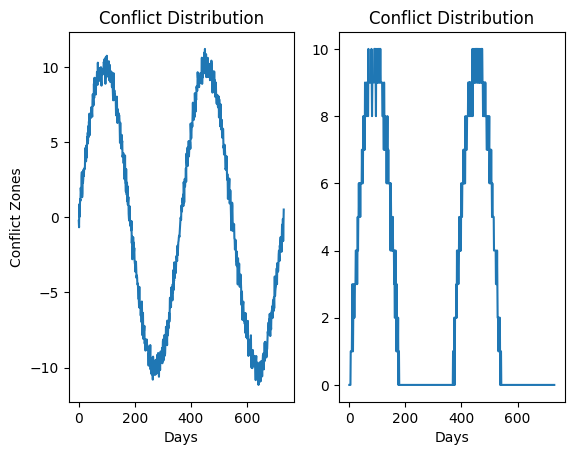

In [19]:
# Snippet 3
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


# Custom function to generate all zeros csv file
def generate_conflict_zones_csv(filename, conflict_zones, period):
    data = {'#Days': list(range(period))}
    data.update({zone: [0] * period for zone in conflict_zones})
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    
# Custom distribution function 1
def custom_distribution1(x):
    peak_day = 100
    max_value = 10
    std_deviation = 130
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor = np.exp(-((x - peak_day) / std_deviation) ** 2)
    
    # Add random fluctuations to the spreading factor
    spreading_factor += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * spreading_factor
    return y


# Custom distribution function 2
def custom_distribution2(x):
    peak_day = 100
    max_value = 10
    std_deviation = 100
    rise_factor = 1.5
    fall_factor = 0.125
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor_rising = np.exp(-((x - peak_day) / std_deviation) ** 2) ** rise_factor
    spreading_factor_falling = np.exp(-((x - peak_day) / (std_deviation * 2)) ** 2) ** fall_factor
    
    # Add random fluctuations to the spreading factors
    spreading_factor_rising += np.random.normal(0, variation_factor, len(x))
    spreading_factor_falling += np.random.normal(0, variation_factor, len(x))
    
    y_rising = max_value * spreading_factor_rising
    y_falling = max_value * spreading_factor_falling
    y = np.where(x < peak_day, y_rising, y_falling)
    return y


# Custom distribution function 3
def custom_distribution3(x):
    peak1_day = 150
    peak2_day = 650
    max_value = 10
    std_deviation1 = 30
    std_deviation2 = 50
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor1 = np.exp(-((x - peak1_day) / std_deviation1) ** 2)
    spreading_factor2 = np.exp(-((x - peak2_day) / std_deviation2) ** 2)
    
    # Add random fluctuations to the spreading factors
    spreading_factor1 += np.random.normal(0, variation_factor, len(x))
    spreading_factor2 += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * (spreading_factor1 + spreading_factor2)
    return y


# Custom distribution function 4
def custom_distribution4(x):
    peak1_day = 150
    peak2_day = 650
    max_value = 10
    std_deviation1 = 30
    std_deviation2 = 50
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor1 = np.exp(-((x - peak1_day) / std_deviation1) ** 2)
    spreading_factor2 = np.exp(-((x - peak2_day) / std_deviation2) ** 2)
    
    # Add random fluctuations to the spreading factors
    spreading_factor1 += np.random.normal(0, variation_factor, len(x))
    spreading_factor2 += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * (spreading_factor1 + spreading_factor2)
    return y


# Custom distribution function 5
def custom_distribution5(x):
    peaks = [100, 200, 300, 400, 500]  # Adjust the peak days as desired
    max_value = 10
    std_deviations = [10, 10, 10, 10, 10]  # Adjust the standard deviations as desired
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factors = []
    for peak, std_deviation in zip(peaks, std_deviations):
        spreading_factor = np.exp(-((x - peak) / std_deviation) ** 2)
        spreading_factor += np.random.normal(0, variation_factor, len(x))
        spreading_factors.append(spreading_factor)
    
    y = max_value * sum(spreading_factors)
    return y


# Custom distribution function 6
def custom_distribution6(x):
    peaks = [150, 300, 450, 600]  # Adjust the peak days as desired
    hill_width = 20  # Adjust the width of the hill
    max_value = 10
    std_deviations = [10, 20, 30, 40]  # Adjust the standard deviations as desired
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factors = []
    for peak, std_deviation in zip(peaks, std_deviations):
        spreading_factor = np.exp(-((x - peak) / std_deviation) ** 2)
        
        # Create the hill shape by adding a flat plateau around the peak
        hill_mask = np.logical_and(x >= peak - hill_width, x <= peak + hill_width)
        spreading_factor[hill_mask] = max_value
        
        spreading_factor += np.random.normal(0, variation_factor, len(x))
        spreading_factors.append(spreading_factor)
    
    y = max_value * sum(spreading_factors)
    return y


# Custom distribution function 7
def custom_distribution7(x):
    period = 365  # Length of one complete period (in days)
    max_value = 10  # Maximum value for conflict intensity
    variation_factor = 0.5  # Adjust the variation factor as desired
    
    # Compute the phase angle based on the day of the year
    phase_angle = (x % period) / period * 2 * np.pi
    
    # Use a sine function to model the seasonal variation
    y = max_value * np.sin(phase_angle)
    
    # Add random noise with the specified variation factor
    y += np.random.normal(0, variation_factor, len(x))
    
    return y



# CSV Headers
conflict_zones = ['Gao', 'Segou', 'Tombouctou', 'Douentza', 'Kayes', 'Sikasso', 'Koulikoro', 'Menaka', 'Kidal', 'Bamako']

# Specify the simulation period
period = 732

# Call the function to generate all zeros csv file
generate_conflict_zones_csv('modified-conflicts.csv', conflict_zones, period)

# Read the CSV file into a DataFrame
df = pd.read_csv("modified-conflicts.csv")

# Generate x-axis values from 0 to 731
x = np.linspace(0, 731, num=732)

# Compute y-axis values using the custom distribution function
y = custom_distribution7(x)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot graph
ax1.plot(x, y)
ax1.set_title('Conflict Distribution')
ax1.set_xlabel('Days')
ax1.set_ylabel('Conflict Zones')

# Convert y values to integers
y = [int(val) for val in y]

modified_rows = []
y_index = 0
for _, row in df.iterrows():
    row = row.values
    if y_index >= len(y):
        break

    number = y[y_index]
    y_index += 1
    assigned_count = 0
    for i in range(1, len(row)):
        if assigned_count < number:
            row[i] = 1
            assigned_count += 1
        else:
            break

    modified_rows.append(row)

# Create modified DataFrame
modified_df = pd.DataFrame(modified_rows, columns=df.columns)

# Compute the sum of each row (excluding the '#Days' column)
sum_values = modified_df.iloc[:, 1:].sum(axis=1)

# Plot the summed values
ax2.plot(x, sum_values)
ax2.set_title('Conflict Distribution')
ax2.set_xlabel('Days')

# Write the modified DataFrame to the CSV file
modified_df.to_csv('modified-conflicts.csv', index=False)


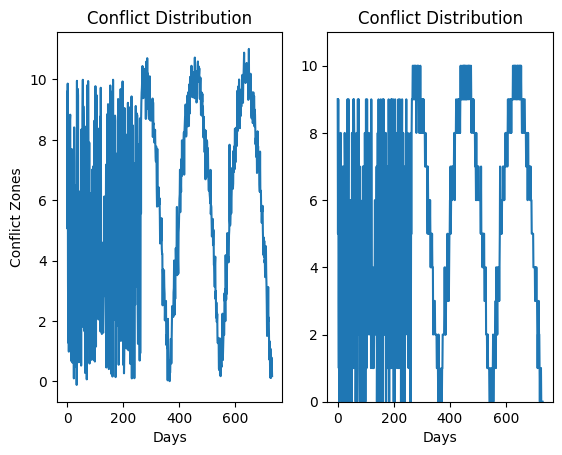

In [57]:
# Snippet 4
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import date

# Custom function to generate all zeros csv file
def generate_conflict_zones_csv(filename, conflict_zones, period):
    data = {'#Days': list(range(period))}
    data.update({zone: [0] * period for zone in conflict_zones})
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

# Generating random numbers
def custom_distribution1(x):
    max_value = 10
    variation_factor = 0.1
    
    # Generate random numbers with the specified maximum value and variation factor
    y = np.random.uniform(0, max_value, len(x))

    # Add random fluctuations to the random numbers
    y += np.random.normal(0, variation_factor, len(x))

    return y


# Custom distribution function 2
def custom_distribution2(x):
    period = 365  # Length of one complete period (in days)
    max_value = 10  # Maximum value for conflict intensity
    variation_factor = 0.5  # Adjust the variation factor as desired

    # Compute the phase angle based on the day of the year
    phase_angle = (x % period) / period * 2 * np.pi

    # Use a sine function to model the seasonal variation
    y = max_value * np.sin(phase_angle)

    # Add random noise with the specified variation factor
    y += np.random.normal(0, variation_factor, len(x))
    y = np.abs(y)  # Take the absolute value of y

    return y


# CSV Headers
conflict_zones = ['Gao', 'Segou', 'Tombouctou', 'Douentza', 'Kayes', 'Sikasso', 'Koulikoro', 'Menaka', 'Kidal', 'Bamako']

# Specify the simulation period
period = 732

# Call the function to generate all zeros csv file
generate_conflict_zones_csv('modified-conflicts.csv', conflict_zones, period)

# Read the CSV file into a DataFrame
df = pd.read_csv("modified-conflicts.csv")

# Generate x-axis values from 0 to 731
start_date = date(2022, 9, 1)
current_date = date.today()
days_passed = (current_date - start_date).days

# Generate x-axis values using custom_distribution1 and custom_distribution2
x1 = np.linspace(0, days_passed, num=days_passed).astype(int)
x2 = np.linspace(days_passed, period, num=period - days_passed).astype(int)

# Generate y-axis values using custom_distribution1 and custom_distribution2
y1 = custom_distribution1(x1)
y2 = custom_distribution2(x2)

# Combine the generated data
x = np.concatenate((x1, x2))
y = np.concatenate((y1, y2))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot graph
ax1.plot(x, y)
ax1.set_title('Conflict Distribution')
ax1.set_xlabel('Days')
ax1.set_ylabel('Conflict Zones')

# Convert y values to integers
y = [int(val) for val in y]

modified_rows = []
y_index = 0
for _, row in df.iterrows():
    row = row.values
    if y_index >= len(y):
        break

    number = y[y_index]
    y_index += 1
    assigned_count = 0
    for i in range(1, len(row)):
        if assigned_count < number:
            row[i] = 1
            assigned_count += 1
        else:
            break

    modified_rows.append(row)

# Create modified DataFrame
modified_df = pd.DataFrame(modified_rows, columns=df.columns)

# Compute the sum of each row (excluding the '#Days' column)
sum_values = modified_df.iloc[:, 1:].sum(axis=1)

# Set the maximum value for the y-axis in Plot 2
max_value = max(max(y), max(sum_values))
ax2.set_ylim(0, max_value)

# Trim x to match the length of sum_values
x = x[:len(sum_values)]

# Plot the summed values
ax2.plot(x, sum_values)
ax2.set_title('Conflict Distribution')
ax2.set_xlabel('Days')

# Write the modified DataFrame to the CSV file
modified_df.to_csv('modified-conflicts.csv', index=False)


In [71]:
# Snippet 5
import pandas as pd
import requests
import json
from shapely.geometry import LineString

# Please add your API key for Google Maps Directions API
API_KEY = ''

# Read the locations from the CSV file
df = pd.read_csv('locations.csv')

# Create a cache for route calculations
route_cache = {}

# Function to calculate route using Google Maps Directions API
def calculate_route(origin, destination):
    cache_key = (origin, destination)
    if cache_key in route_cache:
        return route_cache[cache_key]

    url = f'https://maps.googleapis.com/maps/api/directions/json?origin={origin[0]},{origin[1]}&destination={destination[0]},{destination[1]}&mode=walking&key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    route_cache[cache_key] = data
    return data



# Create a map
m = folium.Map(location=[49.0, 31.0], zoom_start=7)

num_locations_not_found = 0
num_routes_not_found = 0

# Find routes between locations
features = []

for _, origin in df.iterrows():
    origin_name = origin['#name']
    origin_lat = origin['latitude']
    origin_lon = origin['longitude']
    origin_type = origin['location_type']

    for _, destination in df.iterrows():
        destination_name = destination['#name']
        destination_lat = destination['latitude']
        destination_lon = destination['longitude']
        destination_type = destination['location_type']

        # Skip if the origin and destination are the same or have different location types
        if origin_name == destination_name or origin_type != destination_type:
            continue

        # Calculate the route using Google Maps Directions API
        data = calculate_route((origin_lat, origin_lon), (destination_lat, destination_lon))

        if data['status'] == 'OK':
            # Extract the route coordinates
            coordinates = []
            for step in data['routes'][0]['legs'][0]['steps']:
                start_location = step['start_location']
                end_location = step['end_location']
                coordinates.append((start_location['lat'], start_location['lng']))
                coordinates.append((end_location['lat'], end_location['lng']))

            # Create a LineString object from the route coordinates
            route_line = LineString(coordinates)

            # Simplify the LineString by reducing the number of points
            tolerance = 0.001  # Adjust the tolerance for the level of simplification
            simplified_route = route_line.simplify(tolerance)

            # Extract the simplified coordinates from the LineString object
            simplified_coordinates = list(simplified_route.coords)

            # Add the route as a feature to the GeoJSON
            feature = {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": simplified_coordinates
                },
                "properties": {
                    "origin": origin_name,
                    "destination": destination_name
                }
            }

            features.append(feature)
            
            # Add the route as a PolyLine to the map
            folium.PolyLine(locations=simplified_coordinates, color='gray').add_to(m)
        else:
            num_routes_not_found += 1
            
print("Number of routes not found:", num_routes_not_found)

# Create the GeoJSON object
geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Save the GeoJSON to a file
with open("routes.geojson", "w") as file:
    json.dump(geojson, file)
    
    
# Add conflict zones as markers
for _, zone in conflict_zones.iterrows():
    zone_name = zone['#name']
    zone_lat = zone['latitude']
    zone_lon = zone['longitude']
    folium.CircleMarker(location=[zone_lat, zone_lon], radius=6, color='red', fill=True, fill_color='red', popup=zone_name).add_to(m)

# Add towns as markers
for _, town in towns.iterrows():
    town_name = town['#name']
    town_lat = town['latitude']
    town_lon = town['longitude']
    folium.CircleMarker(location=[town_lat, town_lon], radius=6, color='blue', fill=True, fill_color='blue', popup=town_name).add_to(m)

# Add camps as markers
for _, camp in camps.iterrows():
    camp_name = camp['#name']
    camp_lat = camp['latitude']
    camp_lon = camp['longitude']
    folium.CircleMarker(location=[camp_lat, camp_lon], radius=6, color='green', fill=True, fill_color='green', popup=camp_name).add_to(m)


# Save the map as an HTML file
# m.save('map.html')

# Display map
m

Number of routes not found: 0
